In [1]:
#!/usr/bin/env python

Demo: trinidi.cross_section Module
==================================

This script illustrates the functionality of the `trinidi.cross_section` submodule.

In [2]:
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt

from trinidi import cross_section

Available Isotopes
------------------
First we demonstrate how to display available isotopes and display their energy ranges.

The `cross_section.info` function prints out info for all isotopes.

In [3]:
# cross_section.info() # Uncomment this line to print the complete output.

# H-1	10.0 µeV to 20.0 MeV
# H-2	10.0 µeV to 150.0 MeV
# H-3	10.0 µeV to 20.0 MeV
# He-3	10.0 µeV to 20.0 MeV
# He-4	10.0 µeV to 20.0 MeV
# Li-6	10.0 µeV to 20.0 MeV
# Li-7	10.0 µeV to 20.0 MeV
# Be-7	10.0 µeV to 20.0 MeV
# Be-9	10.0 µeV to 20.0 MeV
# B-11	10.0 µeV to 20.0 MeV
# C-12	10.0 µeV to 150.0 MeV
# .
# .
# .

We access a list of all available isotopes using the `cross_section.avail` function.

In [4]:
av_isotopes = cross_section.avail()
print(
    f"av_isotopes = [{av_isotopes[0]}, {av_isotopes[1]}, ..., {av_isotopes[-2]}, {av_isotopes[-1]}]"
)
print(f"Number of isotopes = {len(av_isotopes)}")

av_isotopes = [H-1, H-2, ..., Es-255, Fm-255]
Number of isotopes = 533


You can restrict the displayed isotopes by `cross_section.info` using the `isotopes` optional argument.
Below we subselect all the uranium isotopes.

In [5]:
isotopes_U = [iso for iso in av_isotopes if iso.split("-")[0] == "U"]
print("\nUranium Isotopes:")
cross_section.info(isotopes=isotopes_U)


Uranium Isotopes:
U-230	10.0 µeV to 20.0 MeV
U-231	10.0 µeV to 20.0 MeV
U-232	10.0 µeV to 20.0 MeV
U-233	10.0 µeV to 20.0 MeV
U-234	10.0 µeV to 30.0 MeV
U-235	10.0 µeV to 30.0 MeV
U-236	10.0 µeV to 30.0 MeV
U-237	10.0 µeV to 30.0 MeV
U-238	10.0 µeV to 30.0 MeV
U-239	10.0 µeV to 30.0 MeV
U-240	10.0 µeV to 30.0 MeV
U-241	10.0 µeV to 30.0 MeV


Generate and Plot a Cross Section Dictionary Object `XSDict`
------------------------------------------------------------

First we setup the time-of-flight (TOF) array and requested isotopes list.
Note that the cross section dictionary is sampled with equispaced
samples in TOF.

In [6]:
Δt = 0.30  # bin width [μs]
flight_path_length = 10  # [m]
t_F = np.arange(72, 720, Δt)  # time-of-flight array [μs]
isotopes = ["U-235", "U-238"]

Create a `XSDict` cross section dictionary object.

In [7]:
D = cross_section.XSDict(isotopes, t_F, flight_path_length)
print(D)

<class 'trinidi.cross_section.XSDict'>
    isotopes = ['U-235', 'U-238']
    N_m = 2

    t_F = [72.000 μs, ..., 719.700 μs]
    Δt = 0.300 μs
    N_F = 2160
    flight_path_length = 10.000 m
    E = [100.830 eV, ..., 1.009 eV]

    samples_per_bin = 10

    values.shape = (2, 2160) = (N_m, N_F)
        


The `np.ndarray` `D.values` is a matrix of size `N_m x N_F` that contains the cross section values.

In [8]:
print(f"{D.values.shape = }")

D.values.shape = (2, 2160)


You can plot the dictionary easily with the `XSDict.plot` function.
The optional argument `function_of_energy=False` [default] allows plotting it as a function of
time-of-flight while `function_of_energy=True` plots it as a function of energy.

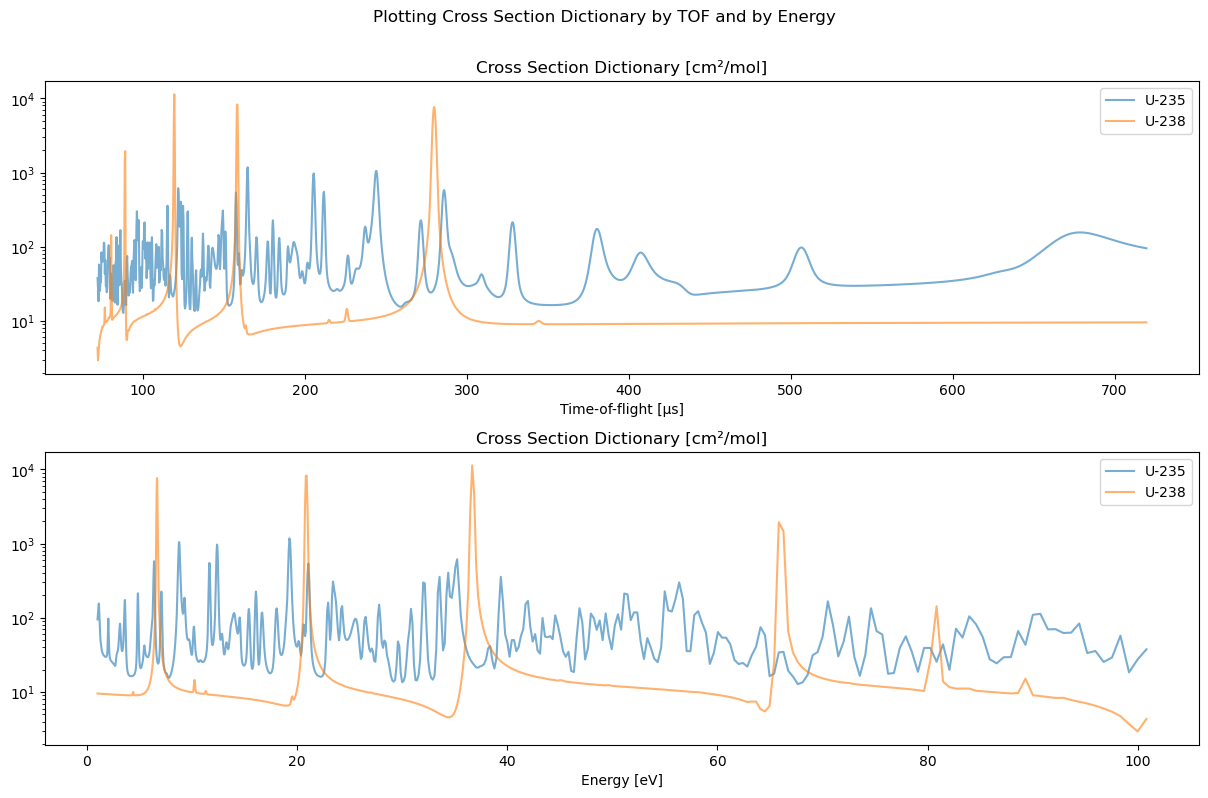

In [9]:
fig, ax = plt.subplots(2, 1, figsize=[12, 8], sharex=False)
ax = np.atleast_1d(ax)
D.plot(ax[0])
D.plot(ax[1], function_of_energy=True)
fig.suptitle("Plotting Cross Section Dictionary by TOF and by Energy")
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0, rect=(0, 0, 1, 0.95))
plt.show()

Creating a Compound Material Cross Section Dictionary
-----------------------------------------------------

When reconstructing a sample with isotopes in known proportions, we recommend combining the
corresponding isotopes according to their known abundances and treating it as a compound material.

For example, below we show how we construct a gold and tungsten (`Au`, `W`) cross section dictionary.
Gold is practically 100% `Au-197` so no action is necessary. However, elemental tungsten consists of several isotopes,

In [10]:
# W-180: 0.12%
# W-182: 26.5%
# W-183: 14.3%
# W-184: 30.6%
# W-186: 28.4%

which we want to combine into a single entry with the use of the `XSDict.merge` function.

We start out with the `XSDict` using all isotopes.
The `D_full` object will stay untouched and used for later comparison.

In [11]:
isotopes_full = ["Au-197", "W-180", "W-182", "W-183", "W-184", "W-186"]
D_full = cross_section.XSDict(isotopes_full, t_F, flight_path_length)

We now define the arguments for the `XSDict.merge` function. The arguments below result in a new
cross section that will be

$$ \sigma_{\mathrm{W}} = 0.0012 \times \sigma_{\mathrm{W180}} + \dots + 0.284 \times \sigma_{\mathrm{W186}}$$

and a new dictionary that will be

$$ D_{\mathrm{new}} = [\sigma_{\mathrm{Au197}}, \sigma_{\mathrm{W}}]^\top$$

In [12]:
merge_isotopes = ["W-180", "W-182", "W-183", "W-184", "W-186"]
merge_weights = [0.0012, 0.265, 0.143, 0.306, 0.284]
new_key = "W"

Below, we generate the modified `XSDict` object, `D_new` from a copy of `D_full`.

In [13]:
D_new = deepcopy(D_full)
isotopes_new = D_new.merge(merge_isotopes, merge_weights, new_key)
print(f"New isotope list: {isotopes_new}")
print(D_new)

New isotope list: ['Au-197', 'W']
<class 'trinidi.cross_section.XSDict'>
    isotopes = ['Au-197', 'W']
    N_m = 2

    t_F = [72.000 μs, ..., 719.700 μs]
    Δt = 0.300 μs
    N_F = 2160
    flight_path_length = 10.000 m
    E = [100.830 eV, ..., 1.009 eV]

    samples_per_bin = 10

    values.shape = (2, 2160) = (N_m, N_F)
        


The `merge_isotopes` cross sections are combined using a weighted sum using the `merge_weights`. All previous isotope keys, `["W-180", "W-182", "W-183", "W-184", "W-186"]`, will be replaced by the `new_key`, `"W"`, which is defined by the user.

(Note that the updated list `XSDict.isotopes` is now not necessarily strictly isotopes since `"W"` is not an isotope. After creation this list primarily serves for plotting and identification of the entries.)

Below we plot and compare the resulting `XSDict` objects.

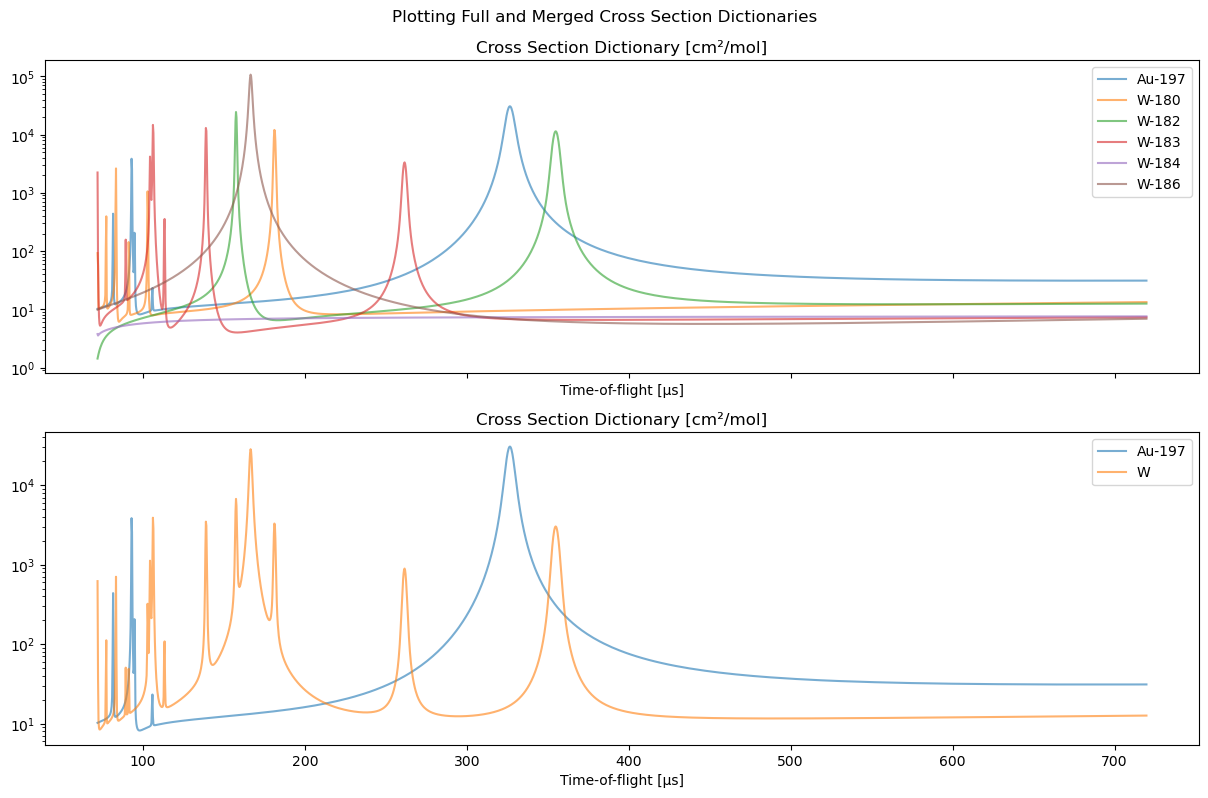

In [14]:
fig, ax = plt.subplots(2, 1, figsize=[12, 8], sharex=True)
ax = np.atleast_1d(ax)
D_full.plot(ax[0])
D_new.plot(ax[1])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0, rect=(0, 0, 1, 0.95))
fig.suptitle("Plotting Full and Merged Cross Section Dictionaries")
plt.show()